#### 라이브러리 호출

In [1]:
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#### 데이터 불러오기

In [2]:
start = (2000, 1, 1)
start = datetime.datetime(*start) 
# end = datetime.date.today() - datetime.timedelta(1) # 어제 날짜
end = datetime.date.today() # 오늘 날짜

In [3]:
df = pdr.DataReader('005930.KS', 'yahoo', start, end) 

In [4]:
df.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,6110.0,5660.0,6000.0,6110.0,74195000.0,4740.119629
2000-01-05,6060.0,5520.0,5800.0,5580.0,74680000.0,4328.947754
2000-01-06,5780.0,5580.0,5750.0,5620.0,54390000.0,4359.979492


In [5]:
df.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-28,83200.0,82100.0,83200.0,82100.0,15596759.0,82100.0
2021-04-29,82500.0,81500.0,82400.0,81700.0,20000973.0,81700.0
2021-04-30,82100.0,81500.0,81900.0,81500.0,17244262.0,81500.0


#### 데이터 분리
* 크게 Train과 Test set으로 나누고
* Train set에서 Train과 validation으로 한번 더 구분한다.  

#### 데이터 정규화
* MinMaxScaler 함수를 사용하여 데이터를 0과 1사이로 변화 -> 정규화
* 신경망학습을 쉽고 빠르게 하기 위하여 필요 

In [6]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i: i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [7]:
TEST_SIZE = 200 
window_size=20

In [8]:
TEST_SIZE = 200 
train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]

In [9]:
feature_cols = ['High', 'Low', 'Open', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

In [10]:
scaler = MinMaxScaler() # 0~1까지 범위변화
train_feature = scaler.fit_transform(train_feature)
train_label = scaler.fit_transform(train_label)
test_feature = scaler.fit_transform(test_feature)
test_label = scaler.fit_transform(test_label)

In [11]:
train_feature = pd.DataFrame(train_feature)
train_feature.columns = feature_cols
train_label = pd.DataFrame(train_label)
train_label.columns = label_cols
test_feature = pd.DataFrame(test_feature)
test_feature.columns = feature_cols
test_label = pd.DataFrame(test_label)
test_label.columns = label_cols


In [12]:
# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 
                                          window_size)
# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 
                                        window_size)

In [13]:
# train, validation set
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, 
                                                      train_label, 
                                                      test_size=0.2)
print('x_train shape :', x_train.shape)
print('x_valid shape :', x_valid.shape)

x_train shape : (4108, 20, 4)
x_valid shape : (1028, 20, 4)


In [14]:
print('test_feature shape :', test_feature.shape)
print('test_label shape :', test_label.shape)

test_feature shape : (180, 20, 4)
test_label shape : (180, 1)


#### 모델 생성

In [15]:
model = Sequential()
model.add(LSTM(16, input_shape = (train_feature.shape[1], 
               train_feature.shape[2]), 
               activation = 'relu', 
               return_sequences=False))
model.add(Dense(1))

#### 모델 학습

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [17]:
history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16, 
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop]
                    )

Epoch 1/200
257/257 [==============================] - 11s 27ms/step - loss: 0.0144 - val_loss: 6.5093e-04
Epoch 2/200
257/257 [==============================] - 3s 12ms/step - loss: 4.9115e-04 - val_loss: 1.9500e-04
Epoch 3/200
257/257 [==============================] - 3s 12ms/step - loss: 2.1297e-04 - val_loss: 1.5042e-04
Epoch 4/200
257/257 [==============================] - 3s 12ms/step - loss: 1.8904e-04 - val_loss: 1.3698e-04
Epoch 5/200
257/257 [==============================] - 3s 11ms/step - loss: 1.5538e-04 - val_loss: 1.3018e-04
Epoch 6/200
257/257 [==============================] - 3s 12ms/step - loss: 1.5314e-04 - val_loss: 1.6185e-04
Epoch 7/200
257/257 [==============================] - 3s 12ms/step - loss: 1.6613e-04 - val_loss: 1.2150e-04
Epoch 8/200
257/257 [==============================] - 3s 12ms/step - loss: 1.5405e-04 - val_loss: 1.2958e-04
Epoch 9/200
257/257 [==============================] - 3s 12ms/step - loss: 1.6544e-04 - val_loss: 1.1829e-04
Epoch 10/200


In [18]:
# 예측
pred = model.predict(test_feature)

#### 데이터 시각화

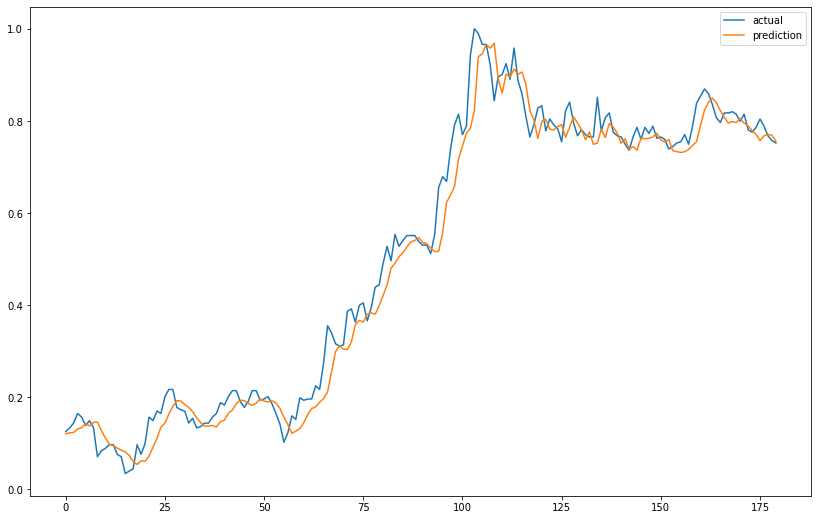

In [19]:
plt.figure(figsize=(14, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [20]:
# 회귀 모델에서의 성능평가는 mse 사용

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_label, pred)
print(mse)

0.0020597508367409946


#### 예측

In [21]:
pred = scaler.inverse_transform(pred)

In [22]:
test_label = scaler.inverse_transform(test_label)

In [23]:
print(pred[-1])
if pred[-1] > test_label[-2]:
    print('상승할 것입니다.')
elif pred[-1] == test_label[-2]:
    print('변동이 없을 것입니다.')
else:
    print('하락할 것입니다.')

[81633.85]
하락할 것입니다.


In [24]:
print(test_label[-1])
if test_label[-1] > test_label[-2]:
    print('상승하였습니다.')
elif test_label[-1] == test_label[-2]:
    print('변동이 없습니다.')
else:
    print('하락하였습니다.')

[81500.]
하락하였습니다.
